# Load Dataset

Let's load the required libraries and dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import string, re
import gc # garbage collector to manage RAM usage
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
nltk.download('wordnet')
  

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
tweets = pd.read_csv('Tweets1.csv')
tweets.head()

,label,tweet
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
# Rename columns to avoid clashes with the words in vocab later
tweets.rename(columns={'label':'Label', 'tweet':'Tweet'}, inplace=True)

# Check distribution of class of tweets
tweets.Label.value_counts()

negative    9178
neutral     3099
positive    2363
Name: Label, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(tweets['Tweet'], tweets['Label'], test_size=0.2, 
                                                    stratify=tweets['Label'], random_state=1)

# Combine the results into train and test dataframe
tweets_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
tweets_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(len(tweets_train))
print(len(tweets_test))
tweets_train.head()

11712
2928


,Tweet,Label
0,@united pls stop sending texts every 15mins sa...,negative
1,@united no thanks,neutral
2,@AmericanAir @NY_NJairports Do you guys teach ...,negative
3,@united I sure did. I had to drive a total o...,negative
4,"@united The guidelines say 10x9x17, my bag is ...",neutral


We now have 25,569 tweets in training dataset and 6,393 tweets in test dataset. 

# Data Preprocessing
We need to first preprocess the tweets to remove hashtags, mentions, punctuations, stopwords, website links, non-alphanumeric characters, single characeter and extra spaces. Here, we'll use `nltk` built-in `TweetTokenizer` to tokenize the sentence. It generally works better than the normal `nltk` `word_tokenize` function as it splits the sentence by taking into consideration of the common patterns seen in tweets (e.g., mention, hashtags, emoji).

In [6]:
def clean_tweet(tweet):
    """
    Tokenize tweets into words. Convert texts to lower case.
    Remove hashtags, punctuations, stopwords, website links, extra spaces, non-alphanumeric characters and 
    single character. Lemmatize texts.
    """
    twt_tokenizer = TweetTokenizer(strip_handles=True) # remove username handles
    tokens = [token for token in twt_tokenizer.tokenize(tweet)]
    
    # Combine stopwords and punctuation
    stops = stopwords.words("english") + list(string.punctuation)
    
    # Create lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    tokens_no_hashtag = [re.sub(r'#', '', token) for token in tokens]
    tokens_no_stopwords = [token.lower() for token in tokens_no_hashtag if token.lower() not in stops]
    tokens_no_url = [re.sub(r'http\S+', '', token) for token in tokens_no_stopwords]
    tokens_no_url = [re.sub(r'www\S+', '', token) for token in tokens_no_url]
    tokens_no_extra_space = [re.sub(r'\s\s+', '', token) for token in tokens_no_url]
    tokens_alnum = [token for token in tokens_no_extra_space if token.isalnum()]
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_alnum]
    tokens_final = [token for token in tokens_lemma if len(token) > 1]
    
    return tokens_final

In [7]:
tweets_train['Tweet'] = tweets_train['Tweet'].apply(clean_tweet)
tweets_train.head()

,Tweet,Label
0,"[pls, stop, sending, text, every, 15mins, sayi...",negative
1,[thanks],neutral
2,"[guy, teach, poor, customer, service, part, am...",negative
3,"[sure, drive, total, hour, get, bag, like, exp...",negative
4,"[guideline, say, 10x9x17, bag, 20x15, 7x8, bit...",neutral


In [8]:
# Combine all the tweets into a single list
corpus = tweets_train['Tweet'].apply(lambda x:' '.join(x))

# Fit CountVectorizer
vectorizer = TfidfVectorizer()
X_train_wc = vectorizer.fit_transform(corpus)
X_train_wc

<11712x10470 sparse matrix of type '<class 'numpy.float64'>'
	with 97619 stored elements in Compressed Sparse Row format>

In [9]:
# Convert y_train and y_test to array
y_train = np.array(tweets_train['Label'])
y_test = np.array(tweets_test['Label'])

# Create X_test_wc using sklearn CountVectorizer
corpus = tweets_test['Tweet'].apply(clean_tweet).apply(lambda x:' '.join(x))
X_test_wc = vectorizer.transform(corpus)

# Ensure the shape of X, y in training and test set is correct
print("Shape of X_train: {}".format(X_train_wc.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test_wc.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (11712, 10470)
Shape of y_train: (11712,)
Shape of X_test: (2928, 10470)
Shape of y_test: (2928,)


In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=99) # default smoothing parameter alpha=1
clf.fit(X_train_wc, y_train)
clf.score(X_test_wc, y_test)

0.764344262295082

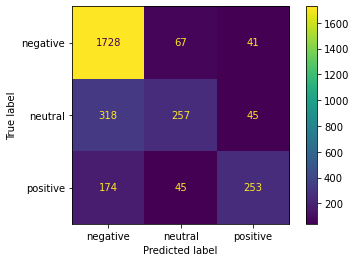

In [11]:
# Generate confusion matrix plot
y_pred = clf.predict(X_test_wc)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [13]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.78      0.94      0.85      1836
     neutral       0.70      0.41      0.52       620
    positive       0.75      0.54      0.62       472

    accuracy                           0.76      2928
   macro avg       0.74      0.63      0.67      2928
weighted avg       0.76      0.76      0.74      2928

